# Analysing real data sets

Let's take a look at some of the analysis and visualisation functionality built into `pandas`. We will work with a real dataset.  The dataset describes COVID-19 cases, hosptialisation and deaths in the Netherlands between Feb and Nov 2020. The dataset is part of a larger public dataset published under a CC-BY 4.0 license. To see the source follow the link below:

> De Bruin, J, Voorvaart, R, Menger, V, Kocken, I, & Phil, T. (2020). Novel Coronavirus (COVID-19) Cases in The Netherlands (Version v2020.11.17) [Data set]. Zenodo. http://doi.org/10.5281/zenodo.4278891

We will use this dataset to put into practice some of existing `pandas` skills and also learn a few new tools to help us understand and visualise the data.

The first actions we will take are importing `numpy` and `pandas`, read in the dataset and have a look at the `DataFrame` information.

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_URL = 'https://raw.githubusercontent.com/health-data-science-OR/' \
            + 'hpdm139-datasets/main/RIVM_NL_provincial.csv'
neth_covid = pd.read_csv(DATA_URL)
neth_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10335 entries, 0 to 10334
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datum             10335 non-null  object 
 1   Provincienaam     9540 non-null   object 
 2   Provinciecode     10335 non-null  int64  
 3   Type              10335 non-null  object 
 4   Aantal            9906 non-null   float64
 5   AantalCumulatief  9945 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 484.6+ KB


The meta data summary of the `Dataframe` provides useful information.  Firstly, we can see that a number of fields have missing data.  Secondly, the column names are in Dutch.  

* Datum = date
* Provincienaam = Province name e.g. 'Gronigen'
* Provinciecode = Province code integer
* Aantal = number 
* AantalCumulatief = cumulative number

Let's take a peek at the head and tail of the dataset.

In [3]:
neth_covid.head()

,Datum,Provincienaam,Provinciecode,Type,Aantal,AantalCumulatief
0,2020-02-27,NaN,-1,Overleden,NaN,NaN
1,2020-02-27,NaN,-1,Totaal,NaN,0.0
2,2020-02-27,NaN,-1,Ziekenhuisopname,NaN,NaN
3,2020-02-27,Groningen,20,Overleden,NaN,NaN
4,2020-02-27,Groningen,20,Totaal,NaN,0.0


In [4]:
neth_covid.tail()

,Datum,Provincienaam,Provinciecode,Type,Aantal,AantalCumulatief
10330,2020-11-17,Noord-Brabant,30,Totaal,847.0,71925.0
10331,2020-11-17,Noord-Brabant,30,Ziekenhuisopname,7.0,3319.0
10332,2020-11-17,Limburg,31,Overleden,0.0,842.0
10333,2020-11-17,Limburg,31,Totaal,266.0,21253.0
10334,2020-11-17,Limburg,31,Ziekenhuisopname,2.0,1743.0


Our peeking has again revealed some useful information. 

* `Provincienaam` is `NaN` (Not a Number i.e. missing) when the reporting the overall totals across all provinces.
* `Aantal` and `AantalCumulatief` record `NaN` in early parts of the pandemic dataset when no cases are being reported. 
* `Type` is a categorical column with three categories in Dutch. Approximate translations are:
    * Totaal = total (positive cases)
    * Ziekenhuisopname = hospital admissions
    * Overleden = deaths attributable to COVID19

## A slight clean-up of the dataset

Now that we have had a look at the raw data let's use `pandas` perform a small clean-up operation that will make our life much easier when we get to analysis.  We will firstly break this procedure down into discrete steps and pull that together is a function.  I'll then show you an alternative cool way of organising your `pandas` using **method chaining**. 

### Translating Dutch Column Names and Categories to English

Let's translate the header columns first.  That's relatively simple as we just replace the list of existing headers with their translations.  We will also update `type` to `metric` as that is more descriptive of the data that the column actually holds.

In [5]:
translated_names = {'Datum':'date', 
                    'Provincienaam':'province', 
                    'Provinciecode':'province_code', 
                    'Type':'metric', 
                    'Aantal':'n', 
                    'AantalCumulatief':'n_cum'}

neth_covid = neth_covid.rename(columns=translated_names)
neth_covid.head()

,date,province,province_code,metric,n,n_cum
0,2020-02-27,NaN,-1,Overleden,NaN,NaN
1,2020-02-27,NaN,-1,Totaal,NaN,0.0
2,2020-02-27,NaN,-1,Ziekenhuisopname,NaN,NaN
3,2020-02-27,Groningen,20,Overleden,NaN,NaN
4,2020-02-27,Groningen,20,Totaal,NaN,0.0


To recode the `metric` column we can use the `.apply(<function>)` method.  This applies a function to each row in the `Dataframe`.  It only makes sense to do this for the `metric` column so we need to be careful about what data we pass in.

In [6]:
# this is a tiered dict {col_name:{dutch key :english value}}
translations = {'metric': {'Overleden':'deaths',
                           'Totaal':'total_cases',
                           'Ziekenhuisopname':'hosp_admit'}}

neth_covid = neth_covid.replace(translations)

In [7]:
neth_covid.head()

,date,province,province_code,metric,n,n_cum
0,2020-02-27,NaN,-1,deaths,NaN,NaN
1,2020-02-27,NaN,-1,total_cases,NaN,0.0
2,2020-02-27,NaN,-1,hosp_admit,NaN,NaN
3,2020-02-27,Groningen,20,deaths,NaN,NaN
4,2020-02-27,Groningen,20,total_cases,NaN,0.0


### Recoding `NaN`

The early case numbers are set to `NaN` as opposed to zero.  The column `province` is always `NaN` when it is reporting the total for all provinces.  Let's update that to `overall`.

To do this we can make use of the `.fillna` method.  We can replace the different fields in one go by passing in a dict that contains a list of column name keys and replacement values

In [8]:
recoding = {'n': 0, 'n_cum': 0, 'province': 'overall'}
neth_covid = neth_covid.fillna(value=recoding)

In [9]:
neth_covid.head()

,date,province,province_code,metric,n,n_cum
0,2020-02-27,overall,-1,deaths,0.0,0.0
1,2020-02-27,overall,-1,total_cases,0.0,0.0
2,2020-02-27,overall,-1,hosp_admit,0.0,0.0
3,2020-02-27,Groningen,20,deaths,0.0,0.0
4,2020-02-27,Groningen,20,total_cases,0.0,0.0


### Correcting the data type of columns

The changes we want to make are:

1. Convert `n` and `n_cum` from floats to integer data types (as it is count data)
2. Set`date` to a proper data time field.
3. Set `metric` to a `Categorical` field (as it only contains three types of category).

> Why bother setting `metric` to have the `Categorical` datatype?  For one thing it slightly reduces memory requirements.  But for me the main benefit is that it tells another third party code, particularly code that is used for plotting, that the field is categorical and should be treated differently.

For casting data types a `pandas.Dataframe` includes the `.astype` method.  This accepts a dict that contains column name keys and datatype values.  Here we will cast to `np.int32`.  The function returns an updated copy of the dataframe.

In [10]:
# change datatype of column
neth_covid = neth_covid.astype({'n': np.int32, 'n_cum': np.int32})

We can deal with the `date` and `metric` columns in one step using the `.assign` method.  The method creates new columns, but you can also use it to overwrite existing ones. The syntax might take a bit of getting used to if you are unfamiliar with **lambda expressions** in python.

For those who are unfamilar a lambda expression is an annoymous function: a function without a name.  Typically they are very simple and used inline within some other code. For example, here is a annoymous function with parameters `a` and `b` that returns the product. 

```python
>>> (lambda a, b: a * b)(5, 2)
```
```
10
```

> Note that the parameters come before the semi-colon and the function logic afterwards.

But like normal functions they are first class objects:

```python
>>> func = (lambda a, b: a * b)
>>> # some other operations and code
>>> func(5, 2)
```
```
10
```

For our purposes in `pandas` we can use it to create a new column.  Here the parameter `x` is actually the `Dataframe`.  So to access the `date` column we use `x['date']` rather than `neth_covid['date']`.

```python
neth_covid = neth_covid.assign(date=lambda x: pd.to_datetime(x['date']))
```

To `assign` more than one colunm add another annoymous function.  The below overwrites `date` and `metric` with updated columns based on the old values. 

> If we wanted to create new columns we would use a different column name.

In [11]:
neth_covid = neth_covid.assign(date=lambda x: pd.to_datetime(x['date']),
                               metric=lambda x: pd.Categorical(x['metric']))  

In [12]:
neth_covid.tail()

,date,province,province_code,metric,n,n_cum
10330,2020-11-17,Noord-Brabant,30,total_cases,847,71925
10331,2020-11-17,Noord-Brabant,30,hosp_admit,7,3319
10332,2020-11-17,Limburg,31,deaths,0,842
10333,2020-11-17,Limburg,31,total_cases,266,21253
10334,2020-11-17,Limburg,31,hosp_admit,2,1743


### Pulling it together in a single function

In summary, we have put together a simple dataset cleaning process in `pandas`.  Let's tidy up our code and put it all in a single function.

In [13]:
def clean_covid_dataset(csv_path):
    '''
    Helper function to clean the netherlands covid dataset.
    
    Params:
    ------
    csv_path: str
        Path or URL to Comman Seperated Value file containing Dutch Covid data.
        
    Returns:
    -------
    pd.Dataframe
        Cleaned Covid19 dataset.
    '''
    translated_names = {'Datum':'date', 
                        'Provincienaam':'province', 
                        'Provinciecode':'province_code', 
                        'Type':'metric', 
                        'Aantal':'n', 
                        'AantalCumulatief':'n_cum'}

    translated_metrics = {'metric': {'Overleden':'deaths',
                                     'Totaal':'total_cases',
                                     'Ziekenhuisopname':'hosp_admit'}}
    df = pd.read_csv(csv_path)
    df = df.rename(columns=translated_names)
    df = df.replace(translated_metrics)
    df = df.fillna(value={'n': 0, 'n_cum': 0, 'province': 'overall'})
    df = df.astype({'n': np.int32, 'n_cum': np.int32})
    df = df.assign(date=lambda x: pd.to_datetime(x['date']),
                   metric=lambda x: pd.Categorical(x['metric']))    
    return df

In [14]:
# test
neth_covid = clean_covid_dataset(DATA_URL)
neth_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10335 entries, 0 to 10334
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           10335 non-null  datetime64[ns]
 1   province       10335 non-null  object        
 2   province_code  10335 non-null  int64         
 3   metric         10335 non-null  category      
 4   n              10335 non-null  int32         
 5   n_cum          10335 non-null  int32         
dtypes: category(1), datetime64[ns](1), int32(2), int64(1), object(1)
memory usage: 333.3+ KB


### Method chaining implementation

The above solution for cleaning the dataset works fine.  However, we can modify our code slightly and (depending on who you ask) make it more elegant and readable using **method chaining**.  

You should notice a pattern in our original `clean_covid_dataset` function.  We repeatedly perform an operation and return a new version of the dataset.  For example, 

```python
# read CSV data and return as dataframe
df = pd.read_csv(path)

# rename columns and return new dataframe
df = df.rename(columns=translated_names)

# replace dutch with english words and return new dataframe
df = df.replace(translated_metrics)
```

Method chaining means that we don't need to actually to include the `df = df.` in each line of the code listing above.  We would instead replace it with the more elegant

```python
df = (pd.read_csv(path)
        .rename(columns=translated_names)
        .replace(translated_metrics)
     )
```

Note that we enclose the chained methods within `(` and `)`.  We also don't need to include the `df` infront of `.rename` and `.replace`.

If we used method chaining our `clean_covid_dataset` function becomes:

In [15]:
def clean_covid_dataset(csv_path):
    '''
    Helper function to clean the netherlands covid dataset.
    
    Params:
    -------
    csv_path: str
        Path to Dutch Covid CSV file
    '''    
    
    translated_names = {'Datum':'date', 
                        'Provincienaam':'province', 
                        'Provinciecode':'province_code', 
                        'Type':'metric', 
                        'Aantal':'n', 
                        'AantalCumulatief':'n_cum'}

    translated_metrics = {'metric': {'Overleden':'deaths',
                                     'Totaal':'total_cases',
                                     'Ziekenhuisopname':'hosp_admit'}}
    
    # method chaining solution.  Can be more readable
    df = (pd.read_csv(csv_path)
            .rename(columns=translated_names)
            .replace(translated_metrics)
            .fillna(value={'n': 0, 'n_cum': 0, 'province': 'overall'})
            .astype({'n': np.int32, 'n_cum': np.int32})
            .assign(date=lambda x: pd.to_datetime(x['date']),
                    metric=lambda x: pd.Categorical(x['metric']))
    )
    
    return df

In [16]:
neth_covid = clean_covid_dataset(DATA_URL)
neth_covid.head()

,date,province,province_code,metric,n,n_cum
0,2020-02-27,overall,-1,deaths,0,0
1,2020-02-27,overall,-1,total_cases,0,0
2,2020-02-27,overall,-1,hosp_admit,0,0
3,2020-02-27,Groningen,20,deaths,0,0
4,2020-02-27,Groningen,20,total_cases,0,0


It is up to you how you implement your `pandas`.  Personally I think method chaining produces quite readable `pandas` code.  Its also less code (I'm a coder and inherently lazy!).  But note that both functions are equivalent and do the same thing!

## Visualising the number of cases over time.

We will be looking at visualisation in more detail when we introduce `matplotlib`For now we will see how `pandas` includes a high level plotting API for `matplotlib`.

### But first.... more wrangling!  

The cleaned dataset is in what we might call a tidy or long format.  That is there are multiple metric entries per date for each province.  We can convert this into a "wide format", where each metric has its own column per date and province using the `pivot_table` method.  

> `pivot_table` is quite a powerful function and there are plenty of options of how to use it.  I recommend experimenting with it on different dataset.  I've always found it useful for tasks similar to the below.

The code below we convert the metric column into six columns: three columns for `n` (the daily count) and `n_cum` (the cumulative count).  We specify that using the `columns` parameter.  We are also creating a `MultiIndex` based on `['province', 'province_code','date']`.  The order you choose here is important for how data is selected.

In [17]:
# wide format
wf_covid = neth_covid.pivot_table(columns=['metric'], 
                                  index=['province', 'province_code','date'])

In [18]:
wf_covid.head()

n                         n_cum  \
metric                            deaths hosp_admit total_cases deaths   
province province_code date                                              
Drenthe  22            2020-02-27      0          0           0      0   
                       2020-02-28      0          0           0      0   
                       2020-02-29      0          0           0      0   
                       2020-03-01      0          0           1      0   
                       2020-03-02      0          0           0      0   

                                                          
metric                            hosp_admit total_cases  
province province_code date                               
Drenthe  22            2020-02-27          0           0  
                       2020-02-28          0           0  
                       2020-02-29          0           0  
                       2020-03-01          0           1  
                       2020-03-02          0           1

What may not be obvious is that we now have a `pandas.Dataframe` with a multi-index.  The `.info()` method reveals the details:

In [19]:
wf_covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3445 entries, ('Drenthe', 22, Timestamp('2020-02-27 00:00:00')) to ('overall', -1, Timestamp('2020-11-17 00:00:00'))
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   (n, deaths)           3445 non-null   int32
 1   (n, hosp_admit)       3445 non-null   int32
 2   (n, total_cases)      3445 non-null   int32
 3   (n_cum, deaths)       3445 non-null   int32
 4   (n_cum, hosp_admit)   3445 non-null   int32
 5   (n_cum, total_cases)  3445 non-null   int32
dtypes: int32(6)
memory usage: 105.8+ KB


Let's take a scenario where we want to select data for the `Groningen` province of the Netherlands.  We can do this using `.loc`

In [20]:
# get the groningen data
wf_covid.loc['Groningen'].head()

n                         n_cum             \
metric                   deaths hosp_admit total_cases deaths hosp_admit   
province_code date                                                         
20            2020-02-27      0          0           0      0          0   
              2020-02-28      0          0           0      0          0   
              2020-02-29      0          0           0      0          0   
              2020-03-01      0          0           0      0          0   
              2020-03-02      0          0           0      0          0   

                                      
metric                   total_cases  
province_code date                    
20            2020-02-27           0  
              2020-02-28           0  
              2020-02-29           0  
              2020-03-01           0  
              2020-03-02           0

This gives us the time series for just Groningen.  But note that we also have the `province_code` column included.  This is the 2nd level of the index - in fact it is redundant here as its value is unique for Groningen.  To remove it modify our indexing:

In [21]:
# get the groningen data.  note that we use 2 keys inside brackets.
wf_covid.loc[('Groningen', 20)].head()

n                         n_cum                       
metric     deaths hosp_admit total_cases deaths hosp_admit total_cases
date                                                                  
2020-02-27      0          0           0      0          0           0
2020-02-28      0          0           0      0          0           0
2020-02-29      0          0           0      0          0           0
2020-03-01      0          0           0      0          0           0
2020-03-02      0          0           0      0          0           0

columns are also a multi-index and we need to use indexing to narrow down the either the daily or cumulative counts.

In [22]:
wf_covid.loc[('Groningen', 20)].columns

MultiIndex([(    'n',      'deaths'),
            (    'n',  'hosp_admit'),
            (    'n', 'total_cases'),
            ('n_cum',      'deaths'),
            ('n_cum',  'hosp_admit'),
            ('n_cum', 'total_cases')],
           names=[None, 'metric'])

In [23]:
# get daily cases
wf_covid.loc[('Groningen', 20)]['n'].head()

metric,deaths,hosp_admit,total_cases
date,,,
2020-02-27,0,0,0
2020-02-28,0,0,0
2020-02-29,0,0,0
2020-03-01,0,0,0
2020-03-02,0,0,0


We can easily plot one or more `Series` in a `Dataframe` by calling the `.plot` method. 

> I tend to think of plot as a kitchen sink method.  Its accepts a very large number of **optional** parameters!  Check out the documentation [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html).  In some ways this is bad practice when designing APIs, but it implementation does turn out to be very handy. 

I would argue that an absolute must is to specify the `figsize`.  For example:

<AxesSubplot:xlabel='date'>

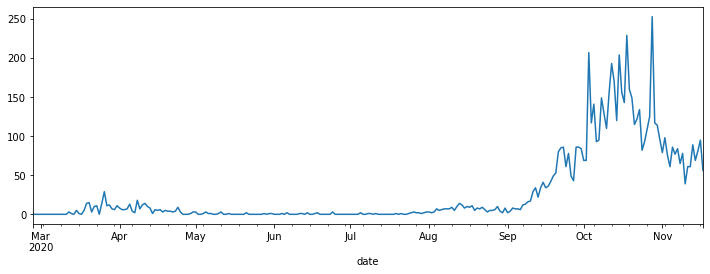

In [24]:
# pandas short hand for plotting daily cases
wf_covid.loc[('Groningen', 20)]['n']['total_cases'].plot(figsize=(12,4))

With default settings in Jupyter you should see the following above the chart:
```
<AxesSubplot:xlabel='date'>
```

This is because `.plot` returns a matplotlib axis object and the text above is the `__repr__`.  The object is very useful, but the print out isn't! For now I'll show you a couple of ways to avoid that appearing in your pristine notebooks.

The first is to assign the axis to a variable.  Convention is that the name `ax` is used.

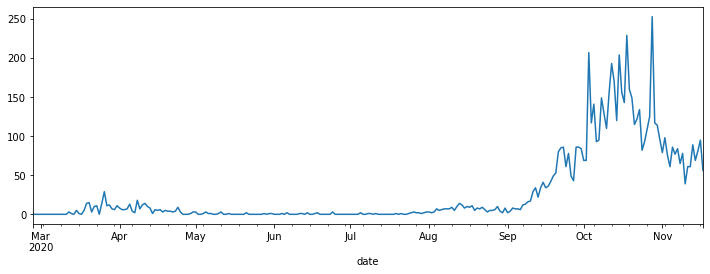

In [25]:
ax = wf_covid.loc[('Groningen', 20)]['n']['total_cases'].plot(figsize=(12,4))

The second approach is to use a semi-colon after the python statement.  I see this used a lot online.  I'm always a bit suspicious this is because the author doesn't really understand what is really happening.  

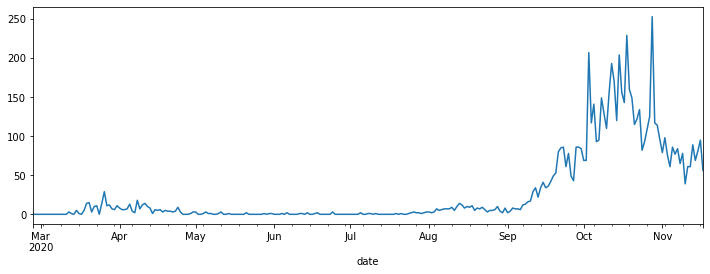

In [26]:
wf_covid.loc[('Groningen', 20)]['n']['total_cases'].plot(figsize=(12,4));